In [1]:
from ROOT  import * #En el ICN no funciona

Welcome to JupyROOT 6.28/04


# Llenar un histograma y hacer fit
## usando pyROOT

 FCN=116.6 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=3.06448e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.81582e+01   1.75014e+00   7.43780e-03  -3.39899e-04
   2  Mean         9.63500e-03   1.44047e-02   7.62630e-05  -1.70389e-02
   3  Sigma        9.94926e-01   1.08268e-02   1.52413e-05   6.11024e-02


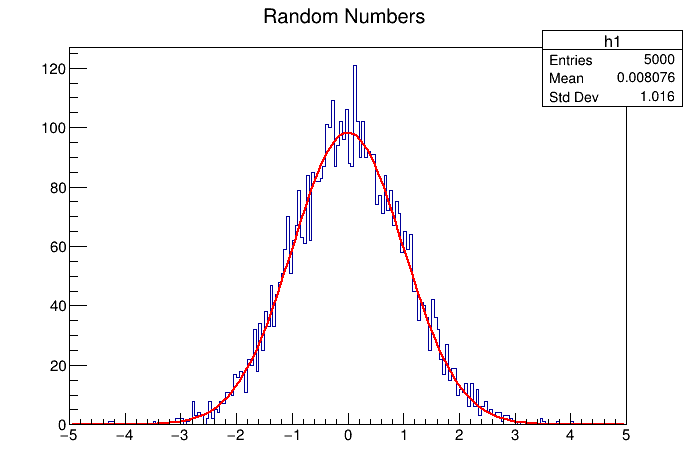

In [2]:
h1=TH1F("h1", "Random Numbers",200,-5,5)

data=h1.FillRandom("gaus")

c1=TCanvas()

h1.Fit("gaus")

h1.Draw()
c1.Draw()

### Obtener mas resultados acerca del ajuste

In [3]:
f = h1.GetFunction("gaus")
print(f.GetNDF())           # Numero de grados de libertad
print(f.GetChisquare())     # Chisquare
print(f.GetProb())          # 

127
116.59974682218747
0.7353736867937091


## Utilizando datos de una imagen FITS

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

import sys

# sys.path.insert(0, '/home/mauricio/Software/Serial_Register_Events_Detection')
# from ReconLib import *

plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})


Filename: /home/bruce/Documents/imagenesMicrochip/14JUN23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_1_NROW_700_NCOL_700_EXPOSURE_1200_NBINROW_1_NBINCOL_1_img_7.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 700)   float32   
  1                1 ImageHDU       164   (700, 700)   float32   
  2                1 ImageHDU       164   (700, 700)   float32   
  3                1 ImageHDU       164   (700, 700)   float32   
None
----------------


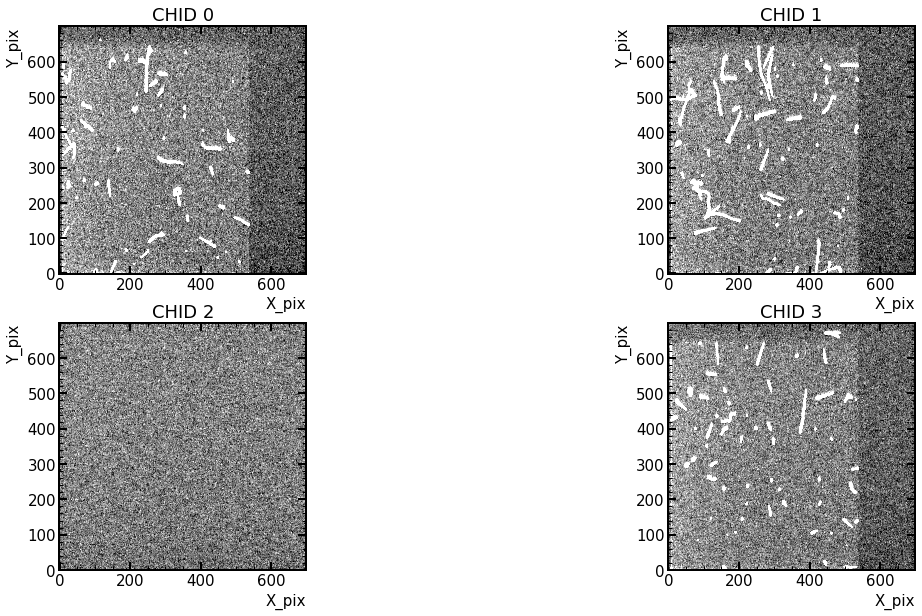

In [3]:
# path='/home/mauricio/datosFits/spuriousCharge/Microchip/14AUG23/proc_skp_module24_MITLL01_externalVr-4_Vv2_T140__NSAMP225_NROW650_NCOL700_EXPOSURE0_NBINROW1_NBINCOL1_img109.fits'
path =  '/home/bruce/Documents/imagenesMicrochip/14JUN23/proc_skp_m-009_microchip_T_170__Vv82_NSAMP_1_NROW_700_NCOL_700_EXPOSURE_1200_NBINROW_1_NBINCOL_1_img_7.fits'

hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=-800,vmax=800,cmap='gray')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

## En este ejemplo seleccionaremos el area de OS y aplicamos el algoritomo J_Guerra para enmascarar eventos de registro serial

In [4]:
extension = 1
Bins = 500
ratio_keV = 0.0037

active_area = hdu_list[extension-1].data[:, :550]
header = hdu_list[0].header

# print(header)

oScan = hdu_list[extension-1].data[:,550:]
hist , bins_edges = np.histogram(oScan.flatten(), bins = Bins)
offset = bins_edges[np.argmax(hist)]
expgain = [227, 220.4, 94.72, 197.7]

Overscan_plane = oScan - offset


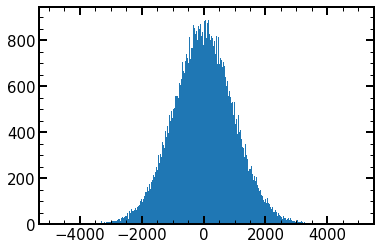

In [5]:
histo, bins,_ = plt.hist(Overscan_plane.flatten(), bins=500)

## La distribucion de pixeles que esperamos es una doble gaussiana, de la cual tenemos una curva que hemos utilizado anteriormente y que podemos definir en ROOT para poder utilizarla en el fit

In [6]:
# definition and parameters of gaussian2: 
# def gaussian2(x,m,s,g,a1,a2): #data, mean = [0] , sigma = [1], gain =[2], height1 = [3], heigth2 = [4]
# in root format: [3]*exp(-1/2*((x-[0])/[1])^2)+[4]*exp(-1/2*((x-[0]-[2])/[1])^2)

# def gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
#     return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)    #esta funcion la usé en python para un ajuste de dos gausianas, 
                                                                          # solo es necesario escribir la funcion de manera compatible con ROOT

# https://root.cern.ch/root/htmldoc/guides/users-guide/FittingHistograms.html
#data, mean = [0] , sigma = [1], gain =[2], height1 = [3], heigth2 = [4]

def gaussian(x, a, mean, sigma): 
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

## Definicion de la variable TFunction 
# fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-200,700,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
fgaus2 = TF1("fgauss","gaus",-4000,4000,3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)



Parameters of the Gaussian Fit
Hight:  511.62385640961145  +-  2.0009642530113547
Mean:  1.0480375650039562  +-  3.0572521497910845
Sigma:  975.0578632190452  +-  2.374885836152714 

chiSquare= 535.9984662167296
NDegrees of Freedom: 497
chiSquare / NDF : 1.0784677388666593 

 FCN=535.998 FROM MIGRAD    STATUS=CONVERGED      55 CALLS          56 TOTAL
                     EDM=1.26962e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.11624e+02   2.00096e+00   1.79522e-02   9.63848e-04
   2  Mean         1.04804e+00   3.05725e+00   3.45901e-02  -9.05219e-05
   3  Sigma        9.75058e+02   2.37489e+00   7.29962e-06   1.88201e+00


Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


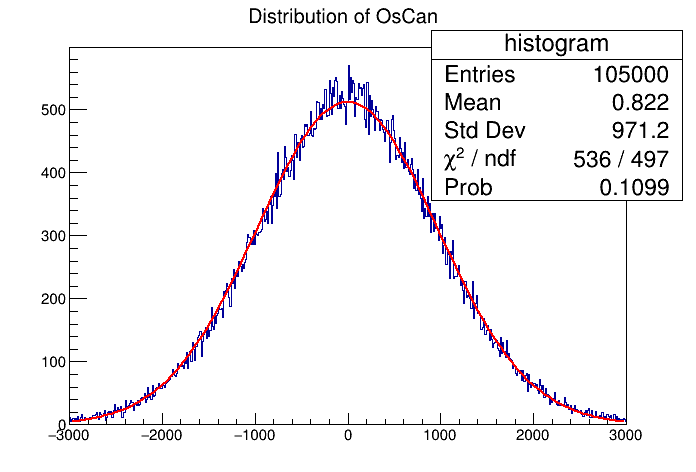

In [8]:
h3=TH1F("histogram", "Distribution of OsCan",500, -3000,3000)

for pixel_value in Overscan_plane.flatten():
    # if not np.ma.is_masked(pixel_value):
    h3.Fill(pixel_value)
        #print(pixel_value)

fgaus2.SetParameters(800,10,100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2)

c3=TCanvas()

h3.Draw()
c3.Draw()
fgaus2.Draw("same")
gStyle.SetOptFit(1100)
gStyle.SetPadGridX (True)
# fgaus2.Draw('Quiet')


print('Parameters of the Gaussian Fit')
print('Hight: ', fgaus2.GetParameters()[0], ' +- ', fgaus2.GetParError(0))
print('Mean: ', fgaus2.GetParameters()[1],  ' +- ', fgaus2.GetParError(1))
print('Sigma: ', fgaus2.GetParameters()[2],  ' +- ', fgaus2.GetParError(2), '\n')



print("chiSquare= "+str(fgaus2.GetChisquare()))
print("NDegrees of Freedom: " + str(fgaus2.GetNDF()))
print("chiSquare / NDF :", fgaus2.GetChisquare() / fgaus2.GetNDF(), '\n')